# 03 - Normal vs. Isolate vs. Deaf

## Imports

In [20]:
import avn.dataloading as dataloading
import avn.acoustics as acoustics
import avn.plotting as plotting
import avn.segmentation as segmentation
import avn.syntax as syntax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import librosa
import os

from numpy.fft import fft, fftfreq
from scipy.signal.windows import hann
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Load Normal and Iso Dataset

In [21]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

Let's drop the Duke deaf and control birds

In [22]:
all_feats_normal = all_feats_normal[~all_feats_normal.Condition.isin(['pre-deafening', 'post-deafening'])]
all_feats_normal.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil'], dtype=object)

## Load Wada Lab Deaf Birds

In [23]:
all_feats_deaf = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\wada_birds_all_feats.csv').drop(columns = 'Unnamed: 0')

In [24]:
all_feats_deaf

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length,Condition
0,0.117747,0.114967,0.121071,2155.357576,2109.599981,2867.423096,-3.266155,-3.448087,-3.060742,61.694346,...,-0.142866,6.848818,0.795698,0.679239,2.085816,0.695272,7,1.180929,0.341734,deaf_120
1,0.138719,0.134799,0.143075,1916.063608,1905.271892,1967.627065,-3.067501,-3.118677,-2.831167,60.048020,...,-0.420613,4.462123,0.623511,0.596916,1.073634,0.415338,5,6.325758,0.855042,deaf_300
2,0.120487,0.115469,0.141427,1761.408783,1563.806841,3297.943880,-3.145204,-3.359798,-2.939603,56.802061,...,-0.186091,4.453035,0.661636,0.792669,2.322015,0.671213,10,2.047170,0.529954,deaf_120
3,0.138086,0.123512,0.146133,1756.748116,1433.786306,2007.303591,-3.356677,-3.532446,-2.834024,56.994473,...,-0.890552,4.523146,0.439880,0.786990,1.312251,0.413969,8,1.200000,0.381881,deaf_300
4,0.114786,0.104775,0.116830,1789.762898,1485.763158,2337.077138,-3.683179,-3.889325,-3.563164,54.013514,...,-0.229416,2.829038,0.684722,0.851385,2.736651,0.823814,9,1.807692,0.555234,deaf_120
5,0.140029,0.123126,0.163307,1837.666285,1569.842809,2464.989868,-2.950556,-3.258490,-2.657295,52.208152,...,-0.814188,3.042721,0.430952,0.581725,1.596453,0.503625,8,2.497939,0.711100,deaf_300
6,0.110085,0.102550,0.135041,2305.491632,1474.451575,3660.457968,-2.612077,-2.928364,-2.373068,52.716926,...,-0.145907,12.336573,0.740859,0.862666,2.236685,0.646547,10,1.750000,0.473804,deaf_120
7,0.131318,0.123017,0.143566,1944.922759,1834.077485,2438.096988,-2.865155,-3.101042,-2.670985,57.502545,...,-0.212056,4.376186,0.636782,0.828545,1.416925,0.504719,6,2.524590,0.623647,deaf_300
8,0.118705,0.113045,0.124365,1804.720076,1590.400913,2019.039239,-3.079158,-3.291822,-2.866493,49.660063,...,-0.176262,7.477644,0.593052,0.866371,0.778098,0.490925,2,5.219178,0.842512,deaf_120
9,0.170568,0.128027,0.179388,1705.981868,1661.570229,1956.193094,-3.513520,-3.598754,-3.245168,58.378313,...,-0.367510,4.838005,0.419097,0.669968,0.814732,0.350886,4,6.861111,0.639381,deaf_300


In [25]:
all_feats_deaf['rhythm_entropy'] = 10**all_feats_deaf.rhythm_entropy

## Merge Datasets

In [26]:
all_feats = pd.concat([all_feats_normal, all_feats_deaf])

In [27]:
all_feats = all_feats.rename(columns = {'entropy_rate_norm' : 'syntax_entropy_rate'})

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [28]:
amplitude_features = all_feats.columns[['Amplitude' in x for x in all_feats.columns.tolist()]]

all_feats = all_feats.drop(columns= amplitude_features)

## Normalize Dataset

In [29]:
features_only = all_feats.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

scaler = StandardScaler()
scaler.fit(feature_mat)

StandardScaler()

In [30]:
all_feats.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil', 'deaf_120', 'deaf_300',
       'sham-deafening'], dtype=object)

In [31]:
normal_iso_deaf = all_feats[~all_feats.Condition.isin([ 'FP1_KD_pre_tut', 'deaf_120'])]

In [32]:
features_only = normal_iso_deaf.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [33]:
class_dict = {'sham-deafening' : 0, 
              'deaf_300' : 1, 
              'FP1_KD_post_tut' : 0, 
              'GFP' : 0, 
              'Pupil' :  0, 
              'Tutor' : 0, 
              'Rockefeller-Pupil': 0,
              'Isolate' : 2, 
              'FP1_KD_pre_tut' : 3}

y = [class_dict[x] for x in normal_iso_deaf.Condition]

## L1-Based Feature Selection

In [34]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [35]:
print(feature_mat_norm.shape)
lsvc = LinearSVC(C=0.1, penalty='l1', dual = False).fit(feature_mat_norm, y)
model = SelectFromModel(lsvc, prefit=True)
x_new = model.transform(feature_mat_norm)
x_new.shape

(103, 43)


(103, 19)

Alright, so this cuts down our feature set from 43 to only 19 features. What are those features? 

In [36]:
feature_idx = [lsvc.coef_.sum(axis = 0) != 0]
features = features_only.columns[np.squeeze(feature_idx)]

In [37]:
features

Index(['Goodness_mean_median', 'Goodness_mean_min', 'Goodness_mean_max',
       'Mean_frequency_mean_max', 'Entropy_mean_median', 'Entropy_mean_min',
       'Entropy_mean_max', 'Frequency_modulation_mean_min', 'Pitch_mean_max',
       'duration_mean_min', 'Goodness_CV_median', 'Mean_frequency_CV_median',
       'Mean_frequency_CV_min', 'duration_CV_min', 'rhythm_entropy',
       'syllable_duration_entropy', 'syntax_entropy_rate',
       'mean_repetition_length', 'CV_repetition_length'],
      dtype='object')

In [41]:
lsvc.coef_.shape

(3, 43)

In [44]:
feature_weights = pd.DataFrame({'feature' : features_only.columns.values, 
                                'weight0' : lsvc.coef_[0],
                                'weight1' : lsvc.coef_[1], 
                                'weight2' : lsvc.coef_[2]})
feature_weights['abs_weight'] = np.abs(feature_weights.weight0) + np.abs(feature_weights.weight1) + np.abs(feature_weights.weight2)
feature_weights.sort_values('abs_weight', ascending=False).head(20)

,feature,weight0,weight1,weight2,abs_weight
40,syntax_entropy_rate,-0.239563,0.000000,0.281853,0.521416
34,duration_CV_min,-0.367662,0.028977,0.108047,0.504686
36,rhythm_entropy,-0.168434,0.000000,0.183914,0.352348
7,Entropy_mean_min,0.099673,0.000000,-0.173732,0.273405
5,Mean_frequency_mean_max,0.002546,-0.248312,0.000000,0.250859
22,Mean_frequency_CV_min,0.000000,0.162057,0.000000,0.162057
0,Goodness_mean_median,0.089301,0.000000,-0.021302,0.110602
1,Goodness_mean_min,0.029849,0.000000,-0.070617,0.100466
8,Entropy_mean_max,0.092141,0.000000,-0.001907,0.094048
38,syllable_duration_entropy,0.000000,0.000000,0.080051,0.080051


In [60]:
for_plotting = feature_weights.set_index('feature')
for_plotting = for_plotting.sort_values('abs_weight', ascending=False)
for_plotting = for_plotting[for_plotting.abs_weight != 0]

In [72]:
plt.rcParams.update({'font.size': 8})

Text(-1.184027777777791, 0.5, '')

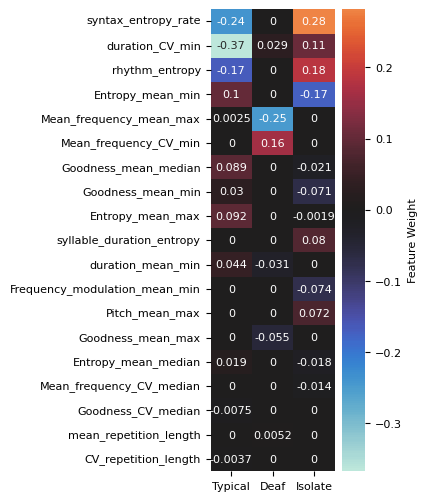

In [75]:
plt.figure(figsize = (2, 6))
sns.heatmap(for_plotting.drop(columns = 'abs_weight'), annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'} )
plt.ylabel('')

weight 0 reflects typical vs. rest, weight 1 reflects deaf vs. rest, and weight 2 reflects isolate vs. rest. 

In [63]:
for_plotting = for_plotting.rename(columns = {'weight0' : 'Typical', 
                                              'weight1' : 'Deaf', 
                                              'weight2' : 'Isolate'})

Text(0.5, 1.0, 'Typical vs. Deaf vs. Isoalte Feature Weights')

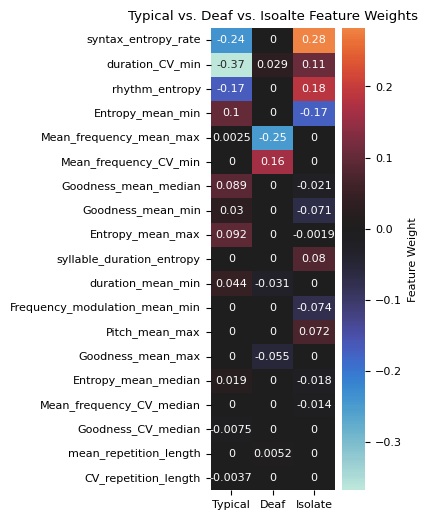

In [77]:
plt.figure(figsize = (2, 6))
sns.heatmap(for_plotting.drop(columns = 'abs_weight'), annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'} )
plt.ylabel('')
plt.title('Typical vs. Deaf vs. Isoalte Feature Weights')

## Classification Without FP1 Birds

In [68]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

In [69]:
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats = 10, random_state=42)
scores = cross_val_score(model, X = x_new, y = y, scoring = 'accuracy', cv = cv, )

In [70]:
scores.mean()

0.9303333333333336

In [71]:
sem(scores)

0.006869000249106958

## Classification with FP1 Birds